# Digit Detection - Fixed Blue Box
Place digit inside the **BLUE** box in center

In [10]:
# IMPORTS
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
%matplotlib inline
print('Libraries loaded!')

Libraries loaded!


In [11]:
# GPU CONFIG
gpu = tf.config.experimental.list_physical_devices('GPU')
print(f"GPU: {len(gpu)}")
if gpu: tf.config.experimental.set_memory_growth(gpu[0], True)

GPU: 0


Train: (60000, 28, 28)


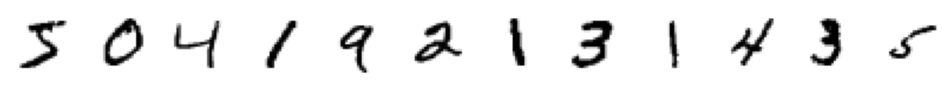

In [12]:
# LOAD DATA
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(f"Train: {x_train.shape}")

# Visualize
plt.figure(figsize=(12,1.5))
for i in range(12):
    plt.subplot(1,12,i+1)
    plt.imshow(x_train[i], cmap='gray_r')
    plt.axis('off')
plt.show()

In [13]:
# NORMALIZE
x_train = x_train.reshape(-1, 784).astype('float32') / 255.0
x_test = x_test.reshape(-1, 784).astype('float32') / 255.0

In [14]:
# BUILD & TRAIN MODEL
model = keras.Sequential([
    keras.Input(shape=(784,)),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(10, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.3)
model.evaluate(x_test, y_test)

Epoch 1/5
657/657 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9208 - loss: 0.2720 - val_accuracy: 0.9577 - val_loss: 0.1455
Epoch 2/5
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9683 - loss: 0.1034 - val_accuracy: 0.9644 - val_loss: 0.1224
Epoch 3/5
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9791 - loss: 0.0668 - val_accuracy: 0.9698 - val_loss: 0.1009
Epoch 4/5
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9857 - loss: 0.0460 - val_accuracy: 0.9689 - val_loss: 0.1090
Epoch 5/5
657/657 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9890 - loss: 0.0352 - val_accuracy: 0.9701 - val_loss: 0.1111
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9735 - loss: 0.0908


[0.09079720824956894, 0.9735000133514404]

---
## Detection with Fixed Blue Box

In [15]:
# PARAMETERS
class Params:
    def __init__(self):
        self.threshold_mode = 0
        self.threshold_value = 127
        self.blur_size = 5
        self.min_confidence = 60
        self.show_help = False

params = Params()

In [16]:
# HELPER FUNCTIONS

def preprocess_roi(roi, blur_size, thresh_mode, thresh_val):
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    k = blur_size if blur_size % 2 == 1 else blur_size + 1
    blur = cv2.GaussianBlur(gray, (k, k), 0)
    if thresh_mode == 0:
        _, binary = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    else:
        _, binary = cv2.threshold(blur, thresh_val, 255, cv2.THRESH_BINARY_INV)
    kernel = np.ones((3, 3), np.uint8)
    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    return cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

def find_digit_contour(binary, min_area=300):
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours: return None
    largest = max(contours, key=cv2.contourArea)
    return largest if cv2.contourArea(largest) >= min_area else None

def prepare_for_prediction(binary, contour):
    x, y, w, h = cv2.boundingRect(contour)
    if w <= 0 or h <= 0: return None
    crop = binary[y:y+h, x:x+w]
    max_dim = max(w, h)
    canvas = np.zeros((max_dim, max_dim), np.uint8)
    canvas[(max_dim-h)//2:(max_dim-h)//2+h, (max_dim-w)//2:(max_dim-w)//2+w] = crop
    padded = cv2.copyMakeBorder(canvas, 15, 15, 15, 15, cv2.BORDER_CONSTANT, value=0)
    return cv2.resize(padded, (28, 28), interpolation=cv2.INTER_AREA)

def predict(digit_img, model):
    flat = digit_img.astype('float32').reshape(1, 784) / 255.0
    pred = model.predict(flat, verbose=0)
    return np.argmax(pred), np.max(pred) * 100

def draw_box_with_corners(frame, x, y, w, h, color, thickness=2):
    corner_len = 20
    cv2.rectangle(frame, (x, y), (x+w, y+h), color, thickness)
    t = thickness + 2
    cv2.line(frame, (x, y), (x+corner_len, y), color, t)
    cv2.line(frame, (x, y), (x, y+corner_len), color, t)
    cv2.line(frame, (x+w, y), (x+w-corner_len, y), color, t)
    cv2.line(frame, (x+w, y), (x+w, y+corner_len), color, t)
    cv2.line(frame, (x, y+h), (x+corner_len, y+h), color, t)
    cv2.line(frame, (x, y+h), (x, y+h-corner_len), color, t)
    cv2.line(frame, (x+w, y+h), (x+w-corner_len, y+h), color, t)
    cv2.line(frame, (x+w, y+h), (x+w, y+h-corner_len), color, t)

def draw_help(frame):
    h, w = frame.shape[:2]
    overlay = frame.copy()
    cv2.rectangle(overlay, (w//4, h//4), (3*w//4, 3*h//4), (0,0,0), -1)
    cv2.addWeighted(overlay, 0.85, frame, 0.15, 0, frame)
    lines = ["CONTROLS:", "[T] Threshold Mode", "[+/-] Threshold Val",
             "[B/N] Blur", "[C/V] Confidence", "[H] Help", "[Q] Quit"]
    for i, txt in enumerate(lines):
        cv2.putText(frame, txt, (w//4+20, h//4+30+i*25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)

def handle_key(key, p):
    if key in [ord('t'), ord('T')]: p.threshold_mode = 1 - p.threshold_mode
    elif key in [ord('+'), ord('=')]: p.threshold_value = min(p.threshold_value + 10, 255) if p.threshold_mode else p.threshold_value
    elif key in [ord('-'), ord('_')]: p.threshold_value = max(p.threshold_value - 10, 0) if p.threshold_mode else p.threshold_value
    elif key in [ord('b'), ord('B')]: p.blur_size = min(p.blur_size + 2, 21)
    elif key in [ord('n'), ord('N')]: p.blur_size = max(p.blur_size - 2, 1)
    elif key in [ord('c'), ord('C')]: p.min_confidence = min(p.min_confidence + 5, 99)
    elif key in [ord('v'), ord('V')]: p.min_confidence = max(p.min_confidence - 5, 10)
    elif key in [ord('h'), ord('H')]: p.show_help = not p.show_help

print('Functions ready!')

Functions ready!


In [17]:
# MAIN LOOP - FIXED BLUE BOX IN CENTER

BLUE = (255, 150, 0)
GREEN = (0, 255, 0)
BOX_SIZE = 200

cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

if not cap.isOpened():
    print('ERROR: Cannot open camera!')
else:
    print('Camera ready! Place digit in BLUE box. [H]Help [Q]Quit')

while cap.isOpened():
    ret, frame = cap.read()
    if not ret: break
    
    h, w = frame.shape[:2]
    box_x = (w - BOX_SIZE) // 2
    box_y = (h - BOX_SIZE) // 2
    
    roi = frame[box_y:box_y+BOX_SIZE, box_x:box_x+BOX_SIZE]
    binary = preprocess_roi(roi, params.blur_size, params.threshold_mode, params.threshold_value)
    
    contour = find_digit_contour(binary)
    pred_text, conf_text, box_color = "", "", BLUE
    
    if contour is not None:
        digit_img = prepare_for_prediction(binary, contour)
        if digit_img is not None:
            cls, conf = predict(digit_img, model)
            if conf >= params.min_confidence:
                pred_text, conf_text, box_color = str(cls), f"{conf:.0f}%", GREEN
    
    draw_box_with_corners(frame, box_x, box_y, BOX_SIZE, BOX_SIZE, box_color, 2)
    cv2.putText(frame, "Place digit here", (box_x, box_y-15), cv2.FONT_HERSHEY_SIMPLEX, 0.6, BLUE, 2)
    
    if pred_text:
        cv2.putText(frame, pred_text, (box_x+BOX_SIZE//2-30, box_y+BOX_SIZE//2+20), cv2.FONT_HERSHEY_SIMPLEX, 2.5, GREEN, 4)
        cv2.putText(frame, conf_text, (box_x+BOX_SIZE//2-25, box_y+BOX_SIZE//2+50), cv2.FONT_HERSHEY_SIMPLEX, 0.7, GREEN, 2)
    
    mode = "Otsu" if params.threshold_mode == 0 else f"T:{params.threshold_value}"
    cv2.putText(frame, f"Blur:{params.blur_size} | {mode} | Conf:{params.min_confidence}%", (10, h-10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (200,200,200), 1)
    cv2.putText(frame, "[H]Help [Q]Quit", (w-120, h-10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (150,150,150), 1)
    
    if params.show_help: draw_help(frame)
    
    cv2.imshow('Digit Detection', frame)
    cv2.imshow('Binary', binary)
    
    key = cv2.waitKey(1) & 0xFF
    if key in [ord('q'), ord('Q')]: break
    elif key != 255: handle_key(key, params)

Camera ready! Place digit in BLUE box. [H]Help [Q]Quit


In [18]:
# CLEANUP
cap.release()
cv2.destroyAllWindows()
print('Done!')

Done!
